In [341]:
import pandas as pd
import numpy as np
from numba import jit
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.trading import TradingClient
from alpaca.trading.requests import GetCalendarRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.enums import Adjustment

from typing import List, Tuple, Optional

import matplotlib.pyplot as plt
from collections import defaultdict, deque
import numpy as np
import toml
import os
import math

from datetime import datetime
from datetime import datetime, timezone, timedelta

from tqdm import tqdm


# Importing the modules themselves for reloading
import TradePosition
import TouchArea

# Reloading the modules to apply any changes
import importlib
importlib.reload(TradePosition)
importlib.reload(TouchArea)

from TradePosition import TradePosition, SubPosition, export_trades_to_csv
from TouchArea import TouchArea, TouchAreaCollection

from dotenv import load_dotenv


STANDARD_DATETIME_STR = '%Y-%m-%d %H:%M:%S'
ROUNDING_DECIMAL_PLACES = 10  # Choose an appropriate number of decimal places

load_dotenv(override=True)
livepaper = os.getenv('LIVEPAPER')
config = toml.load('../config.toml')

# Replace with your Alpaca API credentials
API_KEY = config[livepaper]['key']
API_SECRET = config[livepaper]['secret']


trading_client = TradingClient(API_KEY, API_SECRET)

In [342]:
def is_security_marginable(symbol: str) -> bool:
    try:
        asset = trading_client.get_asset(symbol)
        return asset.marginable
    except Exception as e:
        print(f"Error checking marginability for {symbol}: {e}")
        return False
    
# # testing purposes
# def is_security_marginable(symbol: str) -> bool:
#     marginable_symbols = {'NVDA', 'MSFT', 'AAPL', 'TJX', 'JNJ', 'AMZN', 'TSLA', 'AZN'}
#     return symbol in marginable_symbols

# for symbol in {'NVDA', 'MSFT', 'AAPL', 'TJX', 'JNJ', 'AMZN', 'TSLA', 'AZN'}:
#     print(symbol, is_security_marginable(symbol))

In [343]:
def get_market_hours(dates):
    """
    Parameters:
    dates (list of str): List of dates in 'YYYY-MM-DD' format.

    Returns:
    
    dict: Dictionary with dates as keys and (market_open, market_close) tuples as values.
    """
    start_date = min(dates)
    end_date = max(dates)
    
    calendar_request = GetCalendarRequest(start=start_date, end=end_date)
    calendar = trading_client.get_calendar(calendar_request)
    
    market_hours = {str(day.date): (day.open, day.close) for day in calendar}
    return market_hours

In [344]:
def calculate_dynamic_levels(df:pd.DataFrame, ema_short=9, ema_long=20):
    """
    Calculate VWAP and EMAs for the dataframe.
    
    :param df: DataFrame with 'close', 'high', 'low', and 'volume' columns
    :param ema_short: Period for the short EMA (default 9)
    :param ema_long: Period for the long EMA (default 20)
    :return: DataFrame with additional columns for VWAP and EMAs
    """
    
    assert 'vwap' in df.columns
    
    # Calculate EMAs
    # df[f'EMA{ema_short}'] = df['close'].ewm(span=ema_short, adjust=False).mean()
    # df[f'EMA{ema_long}'] = df['close'].ewm(span=ema_long, adjust=False).mean()
    
    # Calculate a combined central value
    # df['central_value'] = (df['vwap'] + df[f'EMA{ema_short}'] + df[f'EMA{ema_long}']) / 3
    # df['central_value'] = df['vwap']
    # df['central_value'] = df[f'EMA{ema_short}']
    # df['central_value'] = df[f'EMA{ema_long}']
    
    # 1
    # df['central_value'] = df['close'].ewm(span=26, adjust=True).mean()
    
    # 2
    # df['central_value'] = df['close'].ewm(span=26, adjust=False).mean()
    
    # 3
    # halflife = '26min'  # 26 minutes
    # df['central_value'] = df['close'].ewm(
    #     halflife=halflife,
    #     times=df.index.get_level_values('timestamp'),
    #     adjust=True
    # ).mean()

    # #4
    # span = 26 # span of 26 = 9.006468342000588min
    # alpha = 2 / (span + 1)
    # halflife = np.log(2) / np.log(1 / (1 - alpha))
    # halflife_str = f"{halflife}min"

    # df['central_value'] = df['close'].ewm(
    #     halflife=halflife_str,
    #     times=df.index.get_level_values('timestamp'),
    #     adjust=True
    # ).mean()
    
    #45
    span = 26 # span of 26 = 9.006468342000588min
    alpha = 2 / (span + 1)
    halflife = np.log(2) / np.log(1 / (1 - alpha))
    halflife_str = f"{halflife}min"

    df['central_value'] = df['close'].ewm(
        halflife=halflife_str,
        times=df.index.get_level_values('timestamp'),
        adjust=True
    ).mean()
    df['central_value'] = (df['vwap'] + df['central_value']*2) / 3

In [345]:
@jit(nopython=True)
def process_touches(touches, prices, touch_area_lower, touch_area_upper, level, level_lower_bound, level_upper_bound, is_long, min_touches):
    consecutive_touches = np.full(min_touches, -1, dtype=np.int64)
    count = 0
    prev_price = None
    for i in range(len(prices)):
        price = prices[i]
        is_touch = (prev_price is not None and 
                    ((prev_price < level <= price) or (prev_price > level >= price)) or 
                    (price == level))
        
        if level_lower_bound <= price <= level_upper_bound:
            if is_touch:
                consecutive_touches[count] = touches[i]
                count += 1
                if count == min_touches:
                    return consecutive_touches
        else:
            buy_price = touch_area_upper if is_long else touch_area_lower
            if (is_long and price > buy_price) or (not is_long and price < buy_price):
                consecutive_touches[:] = -1
                count = 0
        
        prev_price = price
    return np.empty(0, dtype=np.int64)  # Return empty array instead of empty list

def calculate_touch_area(levels_by_date, is_long, df, symbol, market_hours, min_touches, bid_buffer_pct, use_median, touch_area_width_agg, multiplier, sell_time):
    current_id = 0
    touch_areas = []
    widths = []

    for date, levels in tqdm(levels_by_date.items()):
        market_open, market_close = market_hours.get(str(date), (None, None))
        if market_open and market_close and sell_time:
            market_close = min(
                datetime.strptime(str(date), '%Y-%m-%d') + timedelta(hours=sell_time.hour, minutes=sell_time.minute),
                market_close - timedelta(minutes=3)
            )
        
        if not market_open or not market_close:
            # print('Hours not available. Skipping',date)
            continue
        
        day_data = df[df.index.get_level_values('timestamp').date == date]
        day_timestamps = day_data.index.get_level_values('timestamp')
        day_timestamps_np = day_timestamps.astype(np.int64)  # Convert to nanoseconds
        day_prices = day_data['close'].values
        day_atr = day_data['MTR' if use_median else 'ATR'].values

        for (level_lower_bound, level_upper_bound, level), touches in levels.items():
            if len(touches) < min_touches:
                continue
            
            touch_timestamps_np = np.array([t.timestamp() * 1e9 for t in touches], dtype=np.int64)  # Convert to nanoseconds
            touch_indices = np.searchsorted(day_timestamps_np, touch_timestamps_np)
            
            touch_area_width = touch_area_width_agg(day_atr[touch_indices]) * multiplier

            if touch_area_width is None or np.isnan(touch_area_width) or touch_area_width <= 0:
                continue
            
            widths.append(touch_area_width)
            
            # SUBJECt TO CHANGE
            touch_area_lower = level - (2 * touch_area_width / 3) if is_long else level - (1 * touch_area_width / 3)
            touch_area_upper = level + (1 * touch_area_width / 3) if is_long else level + (2 * touch_area_width / 3)
            
            # touch_area_lower = level - (1 * touch_area_width / 3) if is_long else level - (2 * touch_area_width / 3)
            # touch_area_upper = level + (2 * touch_area_width / 3) if is_long else level + (1 * touch_area_width / 3)
            
            # touch_area_lower = level - (1 * touch_area_width / 2) if is_long else level - (1 * touch_area_width / 2)
            # touch_area_upper = level + (1 * touch_area_width / 2) if is_long else level + (1 * touch_area_width / 2)
            
            
            
            valid_mask = (day_timestamps[touch_indices] >= market_open) & (day_timestamps[touch_indices] < market_close)
            valid_touch_indices = touch_indices[valid_mask]
            valid_prices = day_prices[valid_touch_indices]
            
            consecutive_touch_indices = process_touches(
                valid_touch_indices, 
                valid_prices,
                touch_area_lower, 
                touch_area_upper,  
                level, 
                level_lower_bound,
                level_upper_bound, 
                is_long, 
                min_touches
            )
            
            if len(consecutive_touch_indices) == min_touches:
                consecutive_touches = day_timestamps[consecutive_touch_indices[consecutive_touch_indices != -1]]
                touch_area = TouchArea(
                    id=current_id,
                    level=level,
                    upper_bound=touch_area_upper,
                    lower_bound=touch_area_lower,
                    touches=consecutive_touches.tolist(),
                    is_long=is_long,
                    min_touches=min_touches,
                    bid_buffer_pct=bid_buffer_pct
                )
                touch_areas.append(touch_area)
                current_id += 1

    return touch_areas, widths

In [346]:
def calculate_touch_detection_area(symbol, start_date, end_date, atr_period=10, multiplier=2, min_touches=2, bid_buffer_pct=0.005, sell_time=None, use_median=False, touch_area_width_agg=np.median):
    """
    Calculate the touch detection area based on custom volatility analysis and identify strong support and resistance levels,
    considering only market hours and selling all positions before a specified time.

    Parameters:
    symbol (str|list): The stock symbol to analyze.
    start_date (str|datetime): The start datetime for historical data (format: 'YYYY-MM-DD HH:MM:SS.%f').
    end_date (str|datetime): The end datetime for historical data (format: 'YYYY-MM-DD HH:MM:SS.%f').
    atr_period (int): The period for calculating Average True Range (ATR).
    multiplier (float): The multiplier for ATR to define the touch detection area width.
    min_touches (int): The minimum number of touches to consider a level as strong support or resistance.
    bid_buffer_pct (float): The percentage above the high or below the low to place a stop market buy.
    sell_time (str): The time to sell all positions before (format: 'HH:MM'). If None or after market close, defaults to market close.
    use_median (bool): Flag to switch between using mean or median for levels and touch areas.
    touch_area_width_agg (function): Aggregation function for calculating touch_area_width based on ATR/MTR, which is based on use_median. Suggested: np.median (default), np.nanmax, np.mean
    
    Returns:
    dict: A dictionary with support and resistance areas for both long and short positions.
    """
    assert end_date > start_date
    
    
    # Alpaca API setup
    client = StockHistoricalDataClient(api_key=API_KEY, secret_key=API_SECRET)

    # Request historical data
    request_params = StockBarsRequest(
        symbol_or_symbols=symbol, # CAN be str or list. but set up for str (1 stock) for now)
        timeframe=TimeFrame.Minute,
        start=start_date if isinstance(start_date, datetime) else datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S.%f'),
        end=end_date if isinstance(end_date, datetime) else datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S.%f'),
        adjustment=Adjustment.ALL
    )
    bars = client.get_stock_bars(request_params)
    df = bars.df
    
    df.index = df.index.set_levels(pd.Series(df.index.get_level_values('timestamp').to_list()).map(lambda x: x.replace(tzinfo=None)), level='timestamp')
    df.sort_index(inplace=True)
    timestamps = df.index.get_level_values('timestamp')
    print(df.columns)
    # print(df)    
    
    df.reset_index().to_csv('bars.csv',index=False)

    # calculate_dynamic_levels(df, ema_short=9, ema_long=30) # default
    calculate_dynamic_levels(df)

    
    # Calculate True Range (TR)
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = np.abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = np.abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=atr_period).mean()
    df['MTR'] = df['TR'].rolling(window=atr_period).median()
    
    
    # Group data by date
    grouped = df.groupby(timestamps.date)
    
    all_support_levels = defaultdict(dict)
    all_resistance_levels = defaultdict(dict)

    def classify_level(level_items, index, day_df):
        return 'resistance' if level_items > day_df.loc[index, 'central_value'] else 'support'
    
    for date, day_df in tqdm(grouped):
        day_timestamps = day_df.index.get_level_values('timestamp')
        
        potential_levels = defaultdict(list)
        w_prev = 0
        
        for i in range(len(day_df)):
            high = day_df['high'].iloc[i]
            low = day_df['low'].iloc[i]
            close = day_df['close'].iloc[i]
            timestamp = day_timestamps[i]
            
            w = (high - low) / 2
            if w == 0:
                w = w_prev
            if w == 0:
                continue
            
            w_prev = w
            
            x = close - w
            y = close + w
            
            # Add this point to its own level
            potential_levels[(x, y)].append(timestamp)
            
            # Check if this point falls within any existing levels
            for (level_x, level_y), touches in potential_levels.items():
                if level_x <= close <= level_y and (level_x, level_y) != (x, y):
                    touches.append(timestamp)

        # Filter for strong levels
        strong_levels = {level: touches for level, touches in potential_levels.items() if len(touches) >= min_touches}

        # Classify levels as support or resistance
        for level, touches in strong_levels.items():
            initial_timestamp = touches[0]
            initial_close = day_df.loc[(symbol, initial_timestamp), 'close']

            classification = classify_level(day_df.loc[(symbol, initial_timestamp), 'close'].item(), (symbol, initial_timestamp), day_df)

            if classification == 'support':
                all_support_levels[date][(level[0], level[1], initial_close)] = touches
            else:
                all_resistance_levels[date][(level[0], level[1], initial_close)] = touches

    
    unique_dates = pd.unique(timestamps.date)
    date_strs = [str(date) for date in unique_dates]
    market_hours = get_market_hours(date_strs)
    
    if sell_time:
        sell_time = datetime.strptime(sell_time, '%H:%M')
    
    long_touch_area, long_widths = calculate_touch_area(
        all_resistance_levels, True, df, symbol, market_hours, min_touches, 
        bid_buffer_pct, use_median, touch_area_width_agg, multiplier, sell_time
    )
    short_touch_area, short_widths = calculate_touch_area(
        all_support_levels, False, df, symbol, market_hours, min_touches, 
        bid_buffer_pct, use_median, touch_area_width_agg, multiplier, sell_time
    )
    
    widths = long_widths + short_widths
    
    final_mask = pd.Series(False, index=df.index)
    for date in unique_dates:
        market_open, market_close = market_hours.get(str(date), (None, None))
        date = datetime.strptime(str(date), '%Y-%m-%d')
        if market_open is None or market_close is None:
            market_open = market_close = date
        elif sell_time:
            market_close = date + timedelta(hours=sell_time.hour, minutes=sell_time.minute)
        mask = (timestamps >= str(market_open)) & (timestamps <= str(market_close))
        final_mask |= mask

    return {
        'symbol': symbol,
        'long_touch_area': long_touch_area,
        'short_touch_area': short_touch_area,
        'market_hours': market_hours,
        'bars': df,
        'mask': final_mask,
        'bid_buffer_pct': bid_buffer_pct,
        'min_touches': min_touches,
        'sell_time': sell_time,
        'use_median': use_median
    }
    
    
# example usage:
# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, multiplier=1.6, min_touches=3, sell_time='16:00', use_median=True, touch_area_width_agg=np.median)
# balance, trades_executed, percent_increase, trades = backtest_strategy(touch_detection_areas)

In [347]:
def plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date, save_path=None):
    symbol = touch_detection_areas['symbol']
    long_touch_area = touch_detection_areas['long_touch_area']
    short_touch_area = touch_detection_areas['short_touch_area']
    market_hours = touch_detection_areas['market_hours']
    df = touch_detection_areas['bars']
    mask = touch_detection_areas['mask']
    bid_buffer_pct = touch_detection_areas['bid_buffer_pct']
    min_touches = touch_detection_areas['min_touches']
    sell_time = touch_detection_areas['sell_time']
    use_median = touch_detection_areas['use_median']

        
    plt.figure(figsize=(14, 7))
    plt.plot(df.index.get_level_values('timestamp'), df['central_value'], label='central_value', color='yellow')
    plt.plot(df.index.get_level_values('timestamp'), df['close'], label='Close Price', color='blue')

    df = df[mask]
    timestamps = df.index.get_level_values('timestamp')

    # Prepare data structures for combined plotting
    scatter_data = defaultdict(lambda: defaultdict(list))
    fill_between_data = defaultdict(list)
    line_data = defaultdict(list)

    def find_area_end_idx(start_idx, area:TouchArea, market_open, market_close):
        assert market_open.date() == market_close.date()
        entry_price = area.get_buy_price
        
        for i in range(start_idx + 1, len(df)):
            current_time = timestamps[i]
            if current_time >= market_close:
                return i
            current_price = df['close'].iloc[i]
            
            if current_time >= area.get_min_touch_time:
                if area.is_long and current_price >= entry_price:
                    return i
                elif not area.is_long and current_price <= entry_price:
                    return i
            
        return len(df) - 1  # If no end condition is met, return the last index
    
    
    def process_area(area: TouchArea):
        if not area.is_active:
            return
        
        mark_pos = area.get_buy_price
        mark_shape = "v" if area.is_long else '^'
        color = 'red' if area.is_long else 'green'

        
        current_date = None
        for i, touch_time in enumerate(area.touches):
            if touch_time in timestamps:
                start_idx = timestamps.get_loc(str(touch_time))
                
                if timestamps[start_idx].date() != current_date:
                    current_date = timestamps[start_idx].date()
                    market_open, market_close = market_hours.get(str(current_date), (None, None))
                    if market_open and market_close and sell_time:
                        market_close = min(
                            datetime.strptime(str(current_date), '%Y-%m-%d') + timedelta(hours=sell_time.hour, minutes=sell_time.minute),
                            market_close - timedelta(minutes=3)
                        )
                
                end_idx = find_area_end_idx(start_idx, area, market_open, market_close)
                x1 = [timestamps[start_idx], area.get_min_touch_time]
                x2 = [area.get_min_touch_time, timestamps[end_idx]]
                
                if timestamps[end_idx] >= market_close:
                    continue
                scatter_color = 'gray' if i != min_touches - 1 else 'red' if end_idx == start_idx else 'blue'
                scatter_data[scatter_color][mark_shape].append((touch_time, mark_pos))
                
                if i == 0:  # first touch
                    fill_between_data[color].append((x1 + x2, [area.lower_bound] * 4, [area.upper_bound] * 4))
                    line_data['blue_alpha'].append((x1, [area.level] * 2))
                    line_data['blue'].append((x2, [area.level] * 2))

    for area in tqdm(long_touch_area + short_touch_area):
        process_area(area)

    # Plot combined data
    for color, shape_data in scatter_data.items():
        for shape, points in shape_data.items():
            if points:
                x, y = zip(*points)
                plt.scatter(x, y, color=color, s=12, marker=shape)

    for color, data in fill_between_data.items():
        for x, lower, upper in data:
            plt.fill_between(x[:2], lower[:2], upper[:2], color=color, alpha=0.1)
            plt.fill_between(x[2:], lower[2:], upper[2:], color=color, alpha=0.25)

    for color, data in line_data.items():
        for x, y in data:
            if color == 'blue_alpha':
                plt.plot(x, y, color='blue', linestyle='-', alpha=0.20)
            else:
                plt.plot(x, y, color='blue', linestyle='-')

    plt.title(f'{symbol} Price Chart with Touch Detection Areas')
    plt.xlabel('Date')
    plt.ylabel('Price')
    # plt.legend(['Close Price', 'Long Touch Area', 'Short Touch Area'])
    plt.legend().remove()
    plt.grid(True)
    
    zstart = datetime.strptime(zoom_start_date, '%Y-%m-%d %H:%M:%S.%f')
    zend = datetime.strptime(zoom_end_date, '%Y-%m-%d %H:%M:%S.%f')

    plt.xlim(max(zstart, timestamps[0]), min(zend, timestamps[-1]))

    ymin, ymax = 0, -1
    for i in range(len(timestamps)):
        if timestamps[i] >= zstart:
            print(timestamps[i])
            ymin = i-1
            break
    for i in range(len(timestamps)):
        if timestamps[i] >= zend:
            print(timestamps[i])
            ymax = i
            break
    ys = df['close'].iloc[max(ymin, 0):min(ymax, len(df))]
    plt.ylim(min(ys),max(ys))
    
    if save_path:
        plt.savefig(save_path)

    plt.show()

In [348]:
# Use the decimal module:
# For financial calculations where precision is crucial, consider using Python's decimal module, which provides exact decimal representations and arithmetic.
# https://docs.python.org/3/library/decimal.html

# from decimal import *
# getcontext()
# # Decimal(3.14)

In [349]:
def backtest_strategy(touch_detection_areas, initial_investment=10000, do_longs=True, do_shorts=True, use_margin=False, times_buying_power=4, min_stop_dist_relative_change_for_partial=0):
    symbol = touch_detection_areas['symbol']
    long_touch_area = touch_detection_areas['long_touch_area']
    short_touch_area = touch_detection_areas['short_touch_area']
    market_hours = touch_detection_areas['market_hours']
    df = touch_detection_areas['bars']
    mask = touch_detection_areas['mask']
    # bid_buffer_pct = touch_detection_areas['bid_buffer_pct']
    min_touches = touch_detection_areas['min_touches']
    sell_time = touch_detection_areas['sell_time']
    # use_median = touch_detection_areas['use_median']
    
    
    debug = False
    def debug_print(message):
        if debug:
            print(message)
            
    assert do_longs or do_shorts
    assert 0 <= min_stop_dist_relative_change_for_partial <= 1
    
    POSITION_OPENED = True
    NO_POSITION_OPENED = False
    
    all_touch_areas = []
    if do_longs:
        all_touch_areas.extend(long_touch_area)
    if do_shorts:
        all_touch_areas.extend(short_touch_area)
    touch_area_collection = TouchAreaCollection(all_touch_areas, min_touches)
        
    is_marginable = is_security_marginable(symbol)
        
    print(f'{symbol} is {'NOT ' if not is_marginable else ''}marginable.')
    # return

    trades = []  # List to store all trades
    
    df = df[mask]
    df = df.sort_index(level='timestamp')
    timestamps = df.index.get_level_values('timestamp')

    balance = initial_investment
    total_account_value = initial_investment
    # buying_power = initial_investment * times_buying_power if use_margin else initial_investment
    
    trades_executed = 0
    open_positions = {}
    current_id = 0
    
    warning_count_insuf_some = 0
    warning_count_insuf_none = 0
    
            
    def update_total_account_value(current_price, name):
        nonlocal total_account_value, balance
        for position in open_positions.values():
            position.update_market_value(current_price)
        
        market_value = sum(position.market_value for position in open_positions.values())
        cash_committed = sum(position.cash_committed for position in open_positions.values())
        total_account_value = balance + cash_committed
        
        if sum(round(position.cash_committed,8) for position in open_positions.values()) > 0:
            print(f"  {name} - update_total_account_value(current_price={current_price}):")
            print(f"    balance: {balance:.6f}")
            print(f"    market_value: {market_value:.6f}")
            print(f"    cash_committed: {cash_committed:.6f}")
            print(f"    total_account_value: {total_account_value:.6f}")
        
            for area_id, position in open_positions.items():
                # position = TradePosition(position)
                print(f"      Position {position.id} in {'res' if position.area.is_long else 'sup'} area {area_id} : Shares: {position.shares}, Market Value: {position.market_value:.6f}, Realized PnL: {position.get_realized_pnl:.2f}, Unrealized PnL: {position.get_unrealized_pnl:.2f}, Cash Committed: {position.cash_committed:.6f}")
                print([f" Sub-position {i}: Shares: {sp.shares}, Entry Price: {sp.entry_price:.4f}, Exit Price: {sp.exit_price if sp.exit_time else np.nan:.4f}" for i, sp in enumerate(position.sub_positions)])
                # for i, sp in enumerate(position.sub_positions):
                #     if sp.exit_time is None:
                #         print(f"        Sub-position {i}: Shares: {sp.shares}, Entry Price: {sp.entry_price:.4f}")
                #     else:
                #         print(f"        Sub-position {i}: Shares: {sp.shares}, Entry Price: {sp.entry_price:.4f}, Exit Price: {sp.exit_price:.4f}")

                                    
    def rebalance(cash_change: float, current_price: float = None):
        nonlocal balance, total_account_value
        old_balance = balance
        new_balance = balance + cash_change
        
        assert new_balance >= 0, f"Negative balance encountered: {new_balance:.2f}"
        
        balance = new_balance

        if current_price is not None:
            update_total_account_value(current_price, 'REBALANCE')
        
        print(f"Rebalance: Old balance: {old_balance:.4f}, Change: {cash_change:.4f}, New balance: {balance:.4f}, Total Account Value: {total_account_value:.4f}")

        s = sum(pos.cash_committed for pos in open_positions.values())
        assert abs(total_account_value - (balance + s)) < 1e-8, \
            f"Total account value mismatch: {total_account_value:.2f} != {balance + s:.2f} ({balance:.2f} + {s:.2f})"
        
        
            
    def exit_action(area_id, position):
        nonlocal trades
        
        print(f"{'res' if position.area.is_long else 'sup'} area {area_id}:\t{position.id} {position.exit_time} - Exit {'Long ' if position.is_long else 'Short'} at {position.exit_price:.4f}")
        
        # Calculate and print additional statistics
        print(f"  Trade Summary:")
        print(f"    Entry Price: {position.entry_price:.4f}")
        print(f"    Exit Price: {position.exit_price:.4f}")
        print(f"    Initial Shares: {position.initial_shares}")
        print(f"    Total P/L: {position.profit_loss:.4f}")
        print(f"    P/L %: {position.profit_loss_percentage:.2f}%")
        print(f"    ROE: {position.return_on_equity:.2f}%")
        print(f"    Holding Time: {position.holding_time}")
        print(f"    Number of Partial Entries: {position.partial_entry_count}")
        print(f"    Number of Partial Exits: {position.partial_exit_count}")
        print(f"    Total Transaction Costs: {position.total_transaction_costs:.4f}")
        
        # Calculate and print transaction statistics
        entry_transactions = [t for t in position.transactions if t.is_entry]
        exit_transactions = [t for t in position.transactions if not t.is_entry]
                        
        print("TRANSACTIONS entry:",f"Total cost: {sum(t.transaction_cost/times_buying_power for t in entry_transactions):.4f} | ", ", ".join([f"({t.value/times_buying_power:.2f}, {t.transaction_cost/times_buying_power:.4f})" for t in entry_transactions]))
        print("TRANSACTIONS exit: ",f"Total cost: {sum(t.transaction_cost/times_buying_power for t in exit_transactions):.4f} | ", ", ".join([f"({t.value/times_buying_power:.2f}, {t.transaction_cost/times_buying_power:.4f})" for t in exit_transactions]))
                
        avg_entry_price = sum(t.price * t.shares for t in entry_transactions) / sum(t.shares for t in entry_transactions)
        avg_exit_price = sum(t.price * t.shares for t in exit_transactions) / sum(t.shares for t in exit_transactions)
        
        print(f"  Transaction Statistics:")
        print(f"    Total Transactions: {len(position.transactions)}")
        print(f"    Entry Transactions: {len(entry_transactions)}")
        print(f"    Exit Transactions: {len(exit_transactions)}")
        print(f"    Average Entry Price: {avg_entry_price:.4f}")
        print(f"    Average Exit Price: {avg_exit_price:.4f}")
        
        # Print any other relevant information
        if position.is_long:
            price_movement = position.exit_price - position.entry_price
        else:
            price_movement = position.entry_price - position.exit_price
        print(f"  Price Movement: {price_movement:.4f} ({(price_movement / position.entry_price) * 100:.2f}%)")
        
        trades.append(position)
            
            
    def close_all_positions(timestamp, exit_price):
        nonlocal trades_executed
        positions_to_remove = []

        for area_id, position in list(open_positions.items()):
            realized_pnl, adjusted_realized_pnl, cash_released = position.partial_exit(timestamp, exit_price, position.shares)
            
            # print('rebalance(cash_released + adjusted_realized_pnl, exit_price)')
            rebalance(cash_released + adjusted_realized_pnl, exit_price)
            
            position.close(timestamp, exit_price)
            trades_executed += 1
            position.area.record_entry_exit(position.entry_time, position.entry_price, 
                                            timestamp, exit_price)
            position.area.terminate(touch_area_collection)
            positions_to_remove.append(area_id)

        temp = {}
        for area_id in positions_to_remove:
            temp[area_id] = open_positions[area_id]
            del open_positions[area_id]
        for area_id in positions_to_remove:
            exit_action(area_id, temp[area_id])

        assert not open_positions
        open_positions.clear()

    
    def calculate_max_position_size(current_price):
        nonlocal balance, use_margin, is_marginable, times_buying_power
        # is_marginable = is_security_marginable(symbol) # called outside to reduce API calls
        
        if use_margin and is_marginable:
            initial_margin_requirement = 0.5  # 50% for marginable securities
        else:
            initial_margin_requirement = 1.0  # 100% for non-marginable securities
            
        overall_margin_multiplier = min(times_buying_power, 4.0)
        actual_margin_multiplier = min(overall_margin_multiplier, 1.0/initial_margin_requirement)
        max_shares = math.floor(balance * overall_margin_multiplier / current_price)
        return max_shares, actual_margin_multiplier, overall_margin_multiplier
    
    
    def place_stop_market_buy(area: TouchArea, timestamp: datetime, open_price: float, high_price: float, low_price: float, close_price: float, prev_close: float):
        nonlocal balance, current_id, total_account_value, open_positions, trades_executed

        if open_positions or balance <= 0:
            return NO_POSITION_OPENED

        # debug_print(f"Attempting order: {'Long' if area.is_long else 'Short'} at {area.get_buy_price:.4f}")
        # debug_print(f"  Balance: {balance:.4f}, Total Account Value: {total_account_value:.4f}")

        # Check if the stop buy would have executed based on high/low. close price unnecessary (i think)
        if area.is_long:
            if prev_close > area.get_buy_price:
                # debug_print(f"  Rejected: Previous close ({prev_close:.4f}) above buy price, likey re-entering area ({area.get_buy_price:.4f})")
                return NO_POSITION_OPENED
            if high_price < area.get_buy_price:
                # debug_print(f"  Rejected: High price ({high_price:.4f}) didn't reach buy price ({area.get_buy_price:.4f})")
                return NO_POSITION_OPENED
        else:  # short
            if prev_close < area.get_buy_price:
                # debug_print(f"  Rejected: Previous close ({prev_close:.4f}) below buy price, likey re-entering area ({area.get_buy_price:.4f})")
                return NO_POSITION_OPENED
            if low_price > area.get_buy_price:
                # debug_print(f"  Rejected: Low price ({low_price:.4f}) didn't reach buy price ({area.get_buy_price:.4f})")
                return NO_POSITION_OPENED

        # Stop buy (placed at time of min_touches) would have executed ############### IMPORTANT
        execution_price = area.get_buy_price

        # Calculate position size, etc...
        max_shares, actual_margin_multiplier, overall_margin_multiplier = calculate_max_position_size(execution_price)
            
        # Recalculate invest_amount based on rounded max_shares
        invest_amount = max_shares * execution_price
        actual_cash_used = invest_amount / overall_margin_multiplier
        
        if actual_cash_used > balance:
            debug_print(f"  Order rejected: Insufficient balance ({actual_cash_used:.4f} > {balance:.4f})")
            return NO_POSITION_OPENED

        debug_print(f"  Shares: {max_shares}, Invest Amount: {invest_amount:.4f}")
        debug_print(f"  Margin Multiplier: {actual_margin_multiplier:.2f}")
        debug_print(f"  execution_price: {execution_price:.2f}")
        
        # Create the position
        position = TradePosition(
            id=current_id,
            area=area,
            is_long=area.is_long,
            entry_time=timestamp,
            initial_balance=actual_cash_used,
            # initial_cash_used=actual_cash_used,
            initial_shares=max_shares,
            entry_price=execution_price,
            use_margin=use_margin,
            is_marginable=is_marginable,
            times_buying_power=overall_margin_multiplier,
            actual_margin_multiplier=actual_margin_multiplier,
            current_stop_price=high_price - area.get_range if area.is_long else low_price + area.get_range,
            max_price=high_price if area.is_long else None,
            min_price=low_price if not area.is_long else None,
        )
            
        # Create sub-positions
        # cash_needed = position.partial_entry(timestamp, execution_price, max_shares)
        cash_needed = position.cash_committed
        
        assert round(position.market_value,10) == round(position.initial_shares * position.entry_price,10), (position.market_value, position.initial_shares * position.entry_price)
        assert round(actual_cash_used,10) == round(position.cash_committed,10), (actual_cash_used, position.cash_committed)
        current_id += 1
        
        # Add to open positions
        open_positions[area.id] = position
        
        print(f"{'res' if area.is_long else 'sup'} area {area.id}: {current_id} {timestamp} - Enter {'Long ' if area.is_long else 'Short'} at {execution_price:.4f}. "
              f"Shares: {max_shares}, Amount: ${invest_amount:.4f} (Margin: {actual_margin_multiplier:.2f}x, Overall: {overall_margin_multiplier:.2f}x, Sub-positions: {len(position.sub_positions)})")

        # print('rebalance(-cash_needed, close_price)')
        rebalance(-cash_needed, close_price)
        return POSITION_OPENED


    def update_positions(timestamp, open_price, high_price, low_price, close_price):
        nonlocal trades_executed, warning_count_insuf_none, warning_count_insuf_some
        positions_to_remove = []
        
        print(f"\nDEBUG: Updating positions at {timestamp}, Close price: {close_price:.4f}")

        def perform_exit(area_id, position):
            nonlocal trades_executed
            position.close(timestamp, position.current_stop_price)
            trades_executed += 1
            position.area.record_entry_exit(position.entry_time, position.entry_price, 
                                            timestamp, position.current_stop_price)
            position.area.terminate(touch_area_collection)
            positions_to_remove.append(area_id)
            

        def calculate_target_shares(position: TradePosition, current_price):
            if position.is_long:
                price_movement = current_price - position.current_stop_price
            else:
                price_movement = position.current_stop_price - current_price
            target_percentage = min(max(0, price_movement / position.area.get_range), 1.0)
            return math.floor(target_percentage * position.initial_shares)

        for area_id, position in open_positions.items():
            # old_stop_price = position.current_stop_price
            # position.update_last_price(close_price)
            print(f"\nDEBUG: Processing position {position.id} for area {area_id}")
            print(f"  Current position - Shares: {position.shares}, Cash committed: {position.cash_committed:.2f}")
            # debug_print(f"Updating position {position.id} at {timestamp}")
            # debug_print(f"  Current shares: {position.shares}, Initial shares: {position.initial_shares}")
            # debug_print(f"  Current stop price: {position.current_stop_price:.4f}")
            
            # # # OHLC logic for trailing stops
            # if position.update_stop_price(open_price):
            #     debug_print(f"  Stop price at open: {position.current_stop_price:.4f} ")
            #     debug_print(f"  Trailing Stop - Exited at open: {open_price:.4f} {'<=' if position.is_long else '>='} {position.current_stop_price:.4f}")
            #     perform_exit(area_id, position)
            #     price_at_action = open_price
            
            # # If not stopped out at open, simulate intra-minute price movement
            # elif not position.is_long and position.update_stop_price(high_price):
            #     # For short positions, the stop is crossed if high price increases past it
            #     debug_print(f"  Stop price at high: {position.current_stop_price:.4f} ")
            #     debug_print(f"  Trailing Stop - Exited at high: {high_price:.4f} {'<=' if position.is_long else '>='} {position.current_stop_price:.4f}")
            #     perform_exit(area_id, position)
            #     price_at_action = high_price
                    
            # elif position.is_long and position.update_stop_price(low_price):
            #     # For long positions, the stop is crossed if low price decreases past it
            #     debug_print(f"  Stop price at low: {position.current_stop_price:.4f} ")
            #     debug_print(f"  Trailing Stop - Exited at low: {low_price:.4f} {'<=' if position.is_long else '>='} {position.current_stop_price:.4f}")
            #     perform_exit(area_id, position)
            #     price_at_action = low_price

            if position.update_stop_price(close_price):
                # debug_print(f"  Stop price at close: {position.current_stop_price:.4f} ")
                # debug_print(f"  Trailing Stop - Exited at close: {close_price:.4f} {'<=' if position.is_long else '>='} {position.current_stop_price:.4f}")
                print(f"  Stop price triggered: {position.current_stop_price:.4f}")
                perform_exit(area_id, position)
                price_at_action = close_price
            else:
                price_at_action = close_price

            # Partial exit and entry logic
            target_shares = calculate_target_shares(position, price_at_action)
            print(f"  Target shares: {target_shares}, Current shares: {position.shares}")
            
            assert target_shares <= position.initial_shares
            
            # print(position.shares, target_shares, position.initial_shares)
            
            target_percentage = target_shares / position.initial_shares
            current_percentage = min(1.0, position.shares / position.initial_shares)
            
            # print(target_shares, position.shares, position.initial_shares)
            assert 0.0 <= target_percentage <= 1.0, target_percentage
            assert 0.0 <= current_percentage <= 1.0, current_percentage

            # To prevent over-trading, skip partial buy/sell if difference between target and current shares percentage is less than threshold
            # BUT only if not increasing/decrease to/from 100%
            
            # min(target_percentage, current_percentage) > 0.0 and max(target_percentage, current_percentage) < 1.0 and
            if  abs(target_percentage - current_percentage) < min_stop_dist_relative_change_for_partial:
                print(f"    SKIP - Current -> Target percentage: {current_percentage*100:.2f}% ({position.shares}) -> {target_percentage*100:.2f}% ({target_shares})")
                continue
            # else:
            #     print(f"    abs(target_percentage - current_percentage): {abs(target_percentage - current_percentage)})")

            if target_shares < position.shares:
                shares_to_adjust = position.shares - target_shares
                print(f"  Initiating partial exit - Shares to sell: {shares_to_adjust}")
                
                if shares_to_adjust > 0:
                    print(f"    Current -> Target percentage: {current_percentage*100:.2f}% ({position.shares}) -> {target_percentage*100:.2f}% ({target_shares})")
                    
                    realized_pnl, adjusted_realized_pnl, cash_released = position.partial_exit(timestamp, price_at_action, shares_to_adjust)
                    print(f"  Partial exit complete - Realized PnL: {realized_pnl:.2f}, Adjusted PnL: {adjusted_realized_pnl:.2f}, Cash released: {cash_released:.2f}")
                    # print('rebalance(cash_released + adjusted_realized_pnl, price_at_action)')
                    rebalance(cash_released + adjusted_realized_pnl, price_at_action)
                    print(f"    Partial exit: Sold {shares_to_adjust} shares at {price_at_action:.4f}, Realized PnL: {adjusted_realized_pnl:.2f}, Cash released: {cash_released:.4f}")

            elif target_shares > position.shares:
                shares_to_adjust = target_shares - position.shares
                print(f"  Initiating partial entry - Shares to buy: {shares_to_adjust}")
                if shares_to_adjust > 0:
                    print(f"    Current -> Target percentage: {current_percentage*100:.2f}% ({position.shares}) -> {target_percentage*100:.2f}% ({target_shares})")
                    
                    # Calculate the maximum number of shares we can buy with the current balance
                    max_shares, actual_margin_multiplier, overall_margin_multiplier = calculate_max_position_size(price_at_action)
                    
                    # Adjust the number of shares to buy if necessary
                    shares_to_buy = min(shares_to_adjust, max_shares)
                    
                    if shares_to_buy > 0:
                        cash_needed = position.partial_entry(timestamp, price_at_action, shares_to_buy)
                        print(f"  Partial entry complete - Shares bought: {shares_to_buy}, Cash used: {cash_needed:.2f}")
                        # print('rebalance(-cash_needed, price_at_action)')
                        rebalance(-cash_needed, price_at_action)
                        print(f"    Partial enter: Bought {shares_to_buy} shares at {price_at_action:.4f}")
                        
                        if shares_to_buy < shares_to_adjust:
                            print(f"    WARNING: Could only buy {shares_to_buy} out of {shares_to_adjust} desired shares due to insufficient balance.")
                            warning_count_insuf_some += 1
                    else:
                        print(f"    WARNING: Insufficient balance to buy any shares. Desired: {shares_to_adjust}, Max possible: {max_shares}")
                        warning_count_insuf_none += 1

        
        # update_total_account_value(close_price, 'BEFORE removing exited positions')
        
        # print(positions_to_remove)
        
        temp = {}
        for area_id in positions_to_remove:
            temp[area_id] = open_positions[area_id]
            del open_positions[area_id]
        for area_id in positions_to_remove:
            exit_action(area_id, temp[area_id])
        
        update_total_account_value(close_price, 'AFTER removing exited positions')
        if positions_to_remove:
            debug_print(f"  Updated Total Account Value: {total_account_value:.4f}")

    # print(f"START\nStrategy: {'Long' if do_longs else ''}{'&' if do_longs and do_shorts else ''}{'Short' if do_shorts else ''}.")
    debug_print(f"Strategy: {'Long' if do_longs else ''}{'&' if do_longs and do_shorts else ''}{'Short' if do_shorts else ''}")
    print(f"{timestamps[0]} -> {timestamps[-1]}")
    # print('Initial Investment:', initial_investment)
    debug_print(f"Initial Investment: {initial_investment}, Times Buying Power: {times_buying_power}")
    print('Number of touch areas:', len(all_touch_areas))
    

    daily_data = None
    current_date, market_open, market_close = None, None, None
    for i in tqdm(range(1, len(timestamps))):
        current_time = timestamps[i]
        print('TIMESTAMP',current_time)
        # print(current_time, len(open_positions))
        
        if current_time.date() != current_date:
            debug_print(f"\nNew trading day: {current_time.date()}")
            # New day, reset daily data
            current_date = current_time.date()
            market_open, market_close = market_hours.get(str(current_date), (None, None))
            if market_open and market_close:
                if sell_time:
                    market_close = min(
                        datetime.strptime(str(current_date), '%Y-%m-%d') + timedelta(hours=sell_time.hour, minutes=sell_time.minute),
                        market_close - timedelta(minutes=3)
                    )
            daily_data = df[timestamps.date == current_date]
            daily_index = 1 # start at 2nd position
            assert not open_positions
        
        if not market_open or not market_close:
            continue

        if market_open <= current_time < market_close and i != len(df)-1:
            # debug_print(f"\n{current_time} - Market Open")
            
            prev_close = daily_data['close'].iloc[daily_index - 1]
            open_price = daily_data['open'].iloc[daily_index]
            high_price = daily_data['high'].iloc[daily_index]
            low_price = daily_data['low'].iloc[daily_index]
            close_price = daily_data['close'].iloc[daily_index]

            
            update_positions(current_time, open_price, close_price, high_price, low_price)
            
            active_areas = touch_area_collection.get_active_areas(current_time)
            for area in active_areas:
                if balance <= 0:
                    break
                if open_positions:
                    break
                
                if (area.is_long and do_longs) or (not area.is_long and do_shorts):

                    if place_stop_market_buy(area, current_time, open_price, high_price, low_price, close_price, prev_close):
                        break  # Exit the loop after placing a position
            
            daily_index += 1
        elif current_time >= market_close:
            debug_print(f"\n{current_time} - Market Close")
            close_all_positions(current_time, df['close'].iloc[i])
        elif i >= len(df)-1:
            debug_print(f"\n{current_time} - Reached last timestamp")
            close_all_positions(current_time, df['close'].iloc[i]) # only for testing. not in live environment

        # print(len(open_positions))
    if current_time >= market_close:
        assert not open_positions

    percent_increase = ((balance - initial_investment) / initial_investment) * 100

    # Buy and hold strategy
    start_price = df['close'].iloc[0]
    end_price = df['close'].iloc[-1]
    buy_and_hold_increase = ((end_price - start_price) / start_price) * 100
    
    total_profit_loss = sum(trade.profit_loss for trade in trades)
    
    total_profit = sum(trade.profit_loss for trade in trades if trade.profit_loss > 0)
    total_loss = sum(trade.profit_loss for trade in trades if trade.profit_loss < 0)
    
    total_transaction_costs = sum(trade.total_transaction_costs for trade in trades)
    
    total_entry_transaction_costs = sum(trade.entry_transaction_costs for trade in trades)
    total_exit_transaction_costs = sum(trade.exit_transaction_costs for trade in trades)
    
    total_short_transaction_costs = sum(trade.total_transaction_costs for trade in trades if not trade.is_long)
    total_long_transaction_costs = sum(trade.total_transaction_costs for trade in trades if trade.is_long)
    
    
    total_stock_borrow_costs = sum(trade.total_stock_borrow_cost for trade in trades)
    
    
    average_profit_loss = total_profit_loss / len(trades) if trades else 0
    average_profit_loss_percentage = sum(trade.profit_loss_percentage for trade in trades) / len(trades) if trades else 0
    
    winning_trades = sum(1 for trade in trades if trade.profit_loss > 0)
    losing_trades = sum(1 for trade in trades if trade.profit_loss < 0)
    
    winning_longs = sum(1 for trade in trades if trade.is_long and trade.profit_loss > 0)
    losing_longs = sum(1 for trade in trades if trade.is_long and trade.profit_loss < 0)
    
    winning_shorts = sum(1 for trade in trades if not trade.is_long and trade.profit_loss > 0)
    losing_shorts = sum(1 for trade in trades if not trade.is_long and trade.profit_loss < 0)

    avg_sub_pos = np.mean([len(trade.sub_positions) for trade in trades])
    avg_transact = np.mean([len(trade.transactions) for trade in trades])
    
    # avg_partial_entry_count = np.mean([trade.partial_entry_count for trade in trades])
    # avg_partial_exit_count = np.mean([trade.partial_exit_count for trade in trades])
    
    # short_count = sum(1 for trade in trades if not trade.is_long)
    # long_count = sum(1 for trade in trades if trade.is_long)
    
    assert trades_executed == len(trades)
    
    debug_print("\nBacktest Complete")
    debug_print(f"Final Balance: {balance:.2f}")
    debug_print(f"Total Trades Executed: {trades_executed}")
    debug_print(f"Win Rate: {winning_trades / len(trades) * 100:.2f}%")

    # Print statistics
    print(f"END\nStrategy: {'Long' if do_longs else ''}{'&' if do_longs and do_shorts else ''}{'Short' if do_shorts else ''}")
    print(f"{timestamps[0]} -> {timestamps[-1]}")

    print("\nOverall Statistics:")
    print('Initial Investment:', initial_investment)
    print('Final Balance:', balance)
    print(f"Percent increase: {percent_increase:.4f}% ***")
    print(f"If held baseline: {buy_and_hold_increase:.4f}%")
    print('Number of Trades Executed:', trades_executed)
    print(f"\nTotal Profit/Loss (including fees): ${total_profit_loss:.2f}")
    print(f"  Total Profit: ${total_profit:.2f}")
    print(f"  Total Loss:   ${total_loss:.2f}")
    print(f"Total Transaction Costs: ${total_transaction_costs:.2f}")
    print(f"  Long:  ${total_long_transaction_costs:.2f}")
    print(f"  Short: ${total_short_transaction_costs:.2f}")
    print(f"\nBorrow Fees: ${total_stock_borrow_costs:.2f}")
    print(f"Average Profit/Loss per Trade (including fees): ${average_profit_loss:.2f}")
    print(f"Average Profit/Loss Percentage per Trade (including fees): {average_profit_loss_percentage:.2f}%")
    print(f"Average Return on Equity per Trade: {sum(trade.return_on_equity for trade in trades) / len(trades):.2f}%")
    print(f"Number of Winning Trades: {winning_trades} ({winning_longs} long, {winning_shorts} short)")
    print(f"Number of Losing Trades:  {losing_trades} ({losing_longs} long, {losing_shorts} short)")
    
    
    print(f"Win Rate: {winning_trades / len(trades) * 100:.2f}%" if trades else "Win Rate: N/A")
    print(f"\nMargin Usage:")
    print(f"Margin Enabled: {'Yes' if use_margin else 'No'}")
    print(f"Max Buying Power: {times_buying_power}x")
    print(f"Average Margin Multiplier: {sum(trade.actual_margin_multiplier for trade in trades) / len(trades):.2f}x")
    print(f"Average Sub Positions per Position: {avg_sub_pos:.2f}")
    print(f"Average Transactions per Position: {avg_transact:.2f}")
    
    # print(trades)
    export_trades_to_csv(trades,'trades_output.csv')
    
    # return balance, trades_executed, percent_increase, trades
    # return balance, trades_executed, percent_increase, winning_trades, losing_trades, winning_trades / len(trades) * 100
    return balance, trades_executed, percent_increase, winning_trades / len(trades) * 100, total_entry_transaction_costs, total_exit_transaction_costs, \
        total_stock_borrow_costs, total_transaction_costs, avg_sub_pos, avg_transact, warning_count_insuf_some, warning_count_insuf_none
    
#     return balance, trades_executed, long_count, short_count, percent_increase, winning_trades / len(trades) * 100




# , total_transaction_costs, \
#         avg_partial_entry_count, avg_partial_exit_count


# avg_sub_pos, avg_transact

In [350]:
# symbol = "NVDA"
# symbol = "MSFT"
# symbol = "AAPL"
# symbol = "TJX"
# symbol = "JNJ"
symbol = "AMZN"
# symbol = "AZN"
# symbol = "TSLA"

# start_date = "2024-06-03 00:00:00.0"
# end_date =   "2024-06-04 00:00:00.0"

# end_date = "2024-03-30 00:00:00.0"


# start_date = "2024-02-01 00:00:00.0"
# end_date   = "2024-03-06 00:00:00.0"
start_date = "2024-02-02 10:30:00.0"
end_date   = "2024-02-02 12:15:00.0"
# start_date = "2024-02-08 00:00:00.0"
# end_date   = "2024-02-15 00:00:00.0"


# start_date = "2023-07-07 00:00:00.0"
# end_date =   "2024-07-07 00:00:00.0"


# start_date = "2023-07-10 00:00:00.0"
# end_date =   "2024-06-26 00:00:00.0"

touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, multiplier=1, min_touches=3, sell_time='16:00', use_median=True, touch_area_width_agg=np.median)


Index(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], dtype='object')


100%|██████████| 1/1 [00:00<00:00, 249.88it/s]


100%|██████████| 18/18 [00:00<00:00, 1123.56it/s]


2024-02-02 10:30:00
2024-02-02 12:15:00


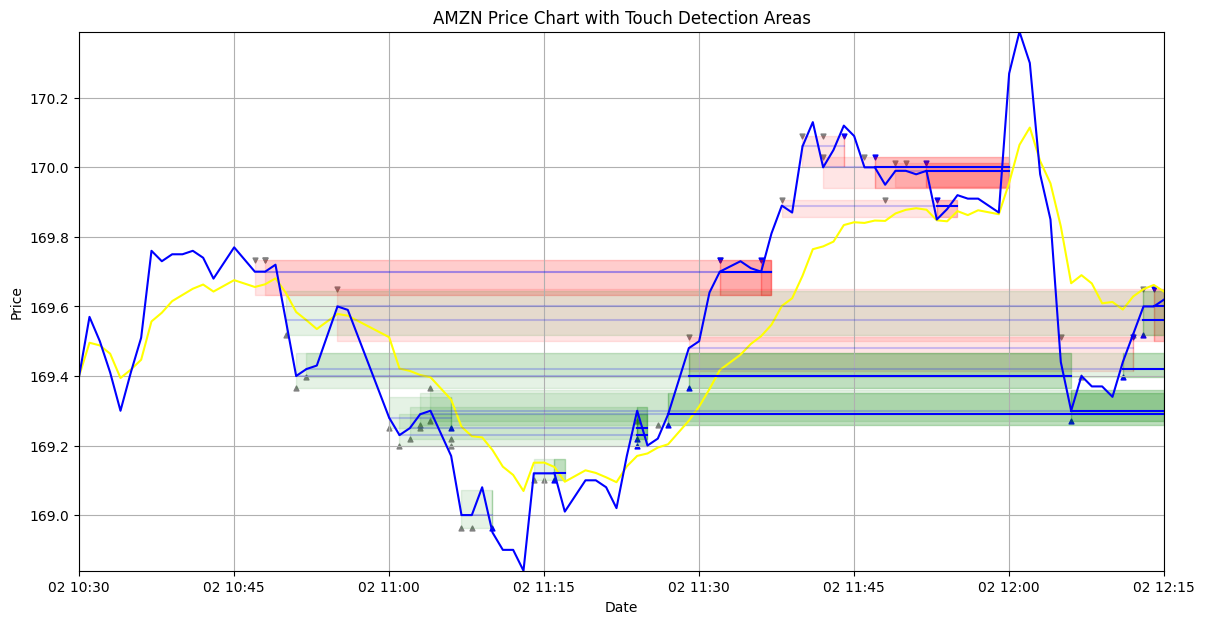

In [351]:

# zoom_start_date = "2024-04-15 00:00:00.0"
# zoom_end_date = "2024-04-15 21:00:00.0"

# i, j = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S.%f'), datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S.%f')

# while i <= j:
#     print(i)
#     zoom_start_date = str(i + timedelta(hours=8))
#     zoom_end_date = str(i + timedelta(hours=20))

#     plot_touch_detection_areas(touch_detection_areas, symbol, zoom_start_date, zoom_end_date)
#     i += timedelta(days=1)

zoom_start_date = start_date
zoom_end_date = end_date
# zoom_start_date = "2024-06-03 14:45:00.0"
# zoom_end_date =   "2024-06-04 16:00:00.0"
plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [352]:

# # Usage examples:
# print("Both Long and Short:")
backtest_strategy( touch_detection_areas, use_margin=True, do_longs=True, do_shorts=True, times_buying_power=2, min_stop_dist_relative_change_for_partial=0)

# # print("\nLong only:")
# backtest_strategy( touch_detection_areas, use_margin=True, do_longs=True, do_shorts=False, times_buying_power=2)
  
# # print("\nShort only:")
# backtest_strategy( touch_detection_areas, use_margin=True, do_longs=False, do_shorts=True, times_buying_power=2)


AMZN is marginable.
2024-02-02 10:30:00 -> 2024-02-02 12:15:00
Number of touch areas: 18


  0%|          | 0/95 [00:00<?, ?it/s]

TIMESTAMP 2024-02-02 10:31:00

DEBUG: Updating positions at 2024-02-02 10:31:00, Close price: 169.4000
TIMESTAMP 2024-02-02 10:32:00

DEBUG: Updating positions at 2024-02-02 10:32:00, Close price: 169.5000
TIMESTAMP 2024-02-02 10:33:00

DEBUG: Updating positions at 2024-02-02 10:33:00, Close price: 169.4100
TIMESTAMP 2024-02-02 10:34:00

DEBUG: Updating positions at 2024-02-02 10:34:00, Close price: 169.3000
TIMESTAMP 2024-02-02 10:35:00

DEBUG: Updating positions at 2024-02-02 10:35:00, Close price: 169.3400
TIMESTAMP 2024-02-02 10:36:00

DEBUG: Updating positions at 2024-02-02 10:36:00, Close price: 169.4100
TIMESTAMP 2024-02-02 10:37:00

DEBUG: Updating positions at 2024-02-02 10:37:00, Close price: 169.5900
TIMESTAMP 2024-02-02 10:38:00

DEBUG: Updating positions at 2024-02-02 10:38:00, Close price: 169.6800
TIMESTAMP 2024-02-02 10:39:00

DEBUG: Updating positions at 2024-02-02 10:39:00, Close price: 169.7000
TIMESTAMP 2024-02-02 10:40:00

DEBUG: Updating positions at 2024-02-02 10

100%|██████████| 95/95 [00:00<00:00, 3707.90it/s]

END
Strategy: Long&Short
2024-02-02 10:30:00 -> 2024-02-02 12:15:00

Overall Statistics:
Initial Investment: 10000
Final Balance: 10005.580000000002
Percent increase: 0.0558% ***
If held baseline: 0.1299%
Number of Trades Executed: 9

Total Profit/Loss (including fees): $3.04
  Total Profit: $30.97
  Total Loss:   $-27.93
Total Transaction Costs: $2.54
  Long:  $1.03
  Short: $1.51

Borrow Fees: $0.03
Average Profit/Loss per Trade (including fees): $0.34
Average Profit/Loss Percentage per Trade (including fees): 0.00%
Average Return on Equity per Trade: 0.00%
Number of Winning Trades: 4 (1 long, 3 short)
Number of Losing Trades:  5 (2 long, 3 short)
Win Rate: 44.44%

Margin Usage:
Margin Enabled: Yes
Max Buying Power: 2x
Average Margin Multiplier: 2.00x
Average Sub Positions per Position: 2.56
Average Transactions per Position: 6.11
Trade summary has been exported to trades_output.csv


(np.float64(10005.580000000002),
 9,
 np.float64(0.05580000000001747),
 44.44444444444444,
 0.125,
 np.float64(2.4166083469074073),
 np.float64(0.029050350308641976),
 np.float64(2.541608346907407),
 np.float64(2.5555555555555554),
 np.float64(6.111111111111111),
 0,
 0)

In [353]:
# balance, trades_executed, percent_increase, winning_trades, losing_trades, winning_trades / len(trades) * 100
# return balance, trades_executed, percent_increase, winning_trades / len(trades) * 100, total_entry_transaction_costs, total_exit_transaction_costs, total_stock_borrow_costs, total_transaction_costs

from IPython.utils import io
# results = pd.DataFrame()
results_list = []
# for i in tqdm(list(np.arange(0.1, 2.01, 0.1))):
for i in tqdm(list(np.arange(0.1, 4.01, 0.1))):
    with io.capture_output() as captured:
        balance, trades_executed, percent_increase, winrate, entry_costs, exit_costs, borrow_costs, total_costs, avg_sub_pos, avg_transact, warning_count_insuf_some, warning_count_insuf_none = \
            backtest_strategy( touch_detection_areas, use_margin=True, do_longs=True, do_shorts=True, times_buying_power=i, min_stop_dist_relative_change_for_partial=0)
        newrow = {'times_buying_power':f'{i:.1f}', 'balance':[f'{balance:.2f}'], 'trades_executed':[trades_executed], 'percent_increase_per_trade':[f'{percent_increase/trades_executed:.6f}'], \
            'winrate':f'{winrate:.6f}', 'entry_costs_per_trade':f'{entry_costs/trades_executed:.6f}', 'exit_costs_per_trade':f'{exit_costs/trades_executed:.6f}', \
                'borrow_costs_per_trade':f'{borrow_costs/trades_executed:.6f}', 'total_costs_per_trade':f'{total_costs/trades_executed:.6f}', \
                    'avg num sub pos created':f'{avg_sub_pos:.2f}', 'avg num transactions':f'{avg_transact:.2f}', 'warning_count_insuf_some':f'{warning_count_insuf_some}', 'warning_count_insuf_none':f'{warning_count_insuf_none}'}
        # results = pd.concat([results, pd.DataFrame.from_dict(newrow)],ignore_index=True)
        results_list.append(pd.DataFrame.from_dict(newrow))
        
results = pd.concat(results_list,ignore_index=True)
results

100%|██████████| 40/40 [00:01<00:00, 27.39it/s]


,times_buying_power,balance,trades_executed,percent_increase_per_trade,winrate,entry_costs_per_trade,exit_costs_per_trade,borrow_costs_per_trade,total_costs_per_trade,avg num sub pos created,avg num transactions,warning_count_insuf_some,warning_count_insuf_none
0,0.1,10002.23,9,0.002481,33.333333,0.344444,0.567438,0.000133,0.911882,3.44,7.00,0,0
1,0.2,10003.35,9,0.003722,44.444444,0.177778,0.424559,0.000297,0.602336,3.33,7.33,0,0
2,0.3,10003.30,9,0.003667,44.444444,0.118519,0.369594,0.000461,0.488113,3.33,7.33,0,0
3,0.4,10003.18,9,0.003537,44.444444,0.086111,0.340988,0.000627,0.427100,3.33,7.22,0,0
4,0.5,10003.25,9,0.003607,44.444444,0.068889,0.324691,0.000791,0.393580,3.33,7.22,0,0
5,0.6,10002.92,9,0.003247,44.444444,0.057407,0.316088,0.000958,0.373495,3.33,7.44,0,0
6,0.7,10002.95,9,0.003275,44.444444,0.049206,0.308002,0.001122,0.357209,3.33,7.44,0,0
7,0.8,10003.02,9,0.003352,44.444444,0.043056,0.301940,0.001287,0.344995,3.33,7.44,0,0
8,0.9,10005.59,9,0.006206,44.444444,0.038272,0.296744,0.001452,0.335016,3.22,7.44,0,0
9,1.0,10008.92,9,0.009911,44.444444,0.030000,0.286845,0.001604,0.316845,2.78,6.56,0,0


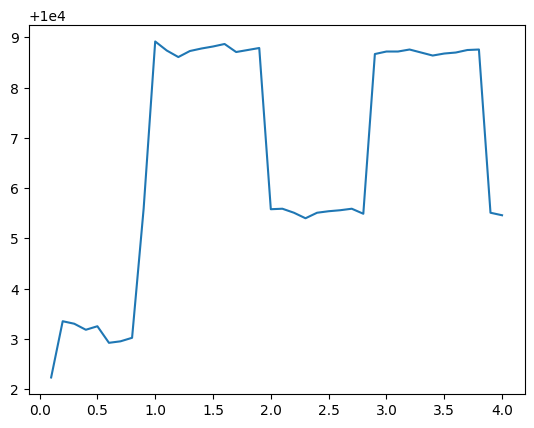

In [354]:
plt.plot(results.times_buying_power.astype(float), results.balance.astype(float))

In [355]:
results.to_csv('times_buying_power_test.csv',index=False)

In [356]:
# results.astype(float).describe()